In [1]:
import time
import numbers
import math

from datetime import date, datetime
from dateutil.parser import parse
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from xgboost import plot_importance

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
train = pd.read_csv('train.csv', sep = ',')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
train.info()
print(train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
(1458644, 11)


In [4]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [5]:
test.info()
print(test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB
(625134, 9)


In [6]:
print('We have {} training rows and {} training columns.'.format(train.shape[0], train.shape[1]))
print('We have {} test rows and {} test columns.'.format(test.shape[0], test.shape[1]))

# test set has missing columns compare with training set.


We have 1458644 training rows and 11 training columns.
We have 625134 test rows and 9 test columns.


In [7]:
start_time = time.time()

for df in (train, test) :
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    df['hr'] = df['pickup_datetime'].dt.hour
    df['minute'] = df['pickup_datetime'].dt.minute
    df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag.values == 'Y')
    
elapsed_time = time.time() - start_time    
print(elapsed_time)

1.0519909858703613


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 14 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null datetime64[ns]
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null int64
year                  625134 non-null int64
month                 625134 non-null int64
day                   625134 non-null int64
hr                    625134 non-null int64
minute                625134 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(8), object(1)
memory usage: 66.8+ MB


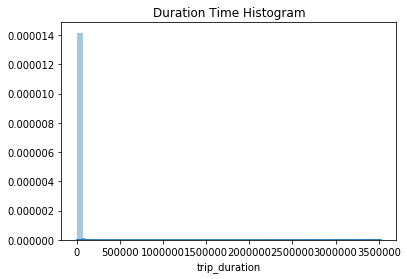

In [9]:
# histogram 모양이 한쪽으로 치우처져 있으므로 log transformation이 필요.
plt.title('Duration Time Histogram')
sns.distplot(train['trip_duration'])

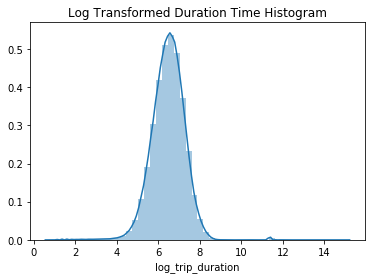

In [10]:
# Using Log transformation, it looks much more similar to normal distribution

train = train.assign(log_trip_duration = np.log1p(train['trip_duration']))
plt.title('Log Transformed Duration Time Histogram')
sns.distplot(train['log_trip_duration'])


In [11]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [12]:
# 뉴욕의 범위는 city_long_border = (-74.03, -73.75), city_lat_border = (40.63, 40.85)

train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

test = test[test['pickup_longitude'] <= -73.75]
test = test[test['pickup_longitude'] >= -74.03]
test = test[test['pickup_latitude'] <= 40.85]
test = test[test['pickup_latitude'] >= 40.63]
test = test[test['dropoff_longitude'] <= -73.75]
test = test[test['dropoff_longitude'] >= -74.03]
test = test[test['dropoff_latitude'] <= 40.85]
test = test[test['dropoff_latitude'] >= 40.63]

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [13]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')

month_train = pd.get_dummies(train['month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['day'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['day'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['hr'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['hr'], prefix='h', prefix_sep='_')

In [14]:
# Let's think about which cases can effect to trip_duration
# 1-1. check Holiday 

holiday = pd.read_csv('NYC_2016Holidays.csv')
holiday['Date'] = holiday['Date'].apply(lambda x : x + ' 2016')
holidays = [datetime.strptime(holiday.loc[i, 'Date'], '%B %d %Y').date() for i in range(len(holiday))]

holidays



[datetime.date(2016, 1, 1),
 datetime.date(2016, 1, 18),
 datetime.date(2016, 2, 12),
 datetime.date(2016, 2, 15),
 datetime.date(2016, 5, 8),
 datetime.date(2016, 5, 30),
 datetime.date(2016, 6, 19),
 datetime.date(2016, 7, 4),
 datetime.date(2016, 9, 5),
 datetime.date(2016, 10, 10),
 datetime.date(2016, 11, 11),
 datetime.date(2016, 11, 24),
 datetime.date(2016, 12, 26),
 datetime.date(2016, 7, 4),
 datetime.date(2016, 11, 8)]

In [15]:
time_train = pd.DataFrame(index= range(len(train)))
time_test = pd.DataFrame(index= range(len(test)))

In [16]:
# 1-2. check Weekend

def rest(year, month, day, holidays) :
    is_weekend = [None] * len(year)
    is_rest = [None] * len(year)
    i = 0
    
    for yy, mm, dd in zip(year, month, day) :
        is_weekend[i] = date(yy,mm,dd).isoweekday() in (6,7)
        # date에서 isoweekday 메소드를 이용해 요일을 반환. 6 = 토요일, 7 = 일요일
        is_rest[i] = is_weekend[i] or date(yy,mm,dd) in holidays
        i += 1
        
    return is_weekend, is_rest

In [17]:
weekend, rest_day = rest(train.year, train.month, train.day, holidays)
time_train = time_train.assign(rest_day = rest_day)
time_train = time_train.assign(weekend = weekend)

rest_day, weekend = rest(test.year, test.month, test.day, holidays)
time_test = time_test.assign(rest_day = rest_day)
time_test = time_test.assign(weekend = weekend)

time_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616934 entries, 0 to 616933
Data columns (total 2 columns):
rest_day    616934 non-null bool
weekend     616934 non-null bool
dtypes: bool(2)
memory usage: 1.2 MB


In [18]:
train = pd.concat([train, time_train], axis = 1)
test = pd.concat([test, time_test], axis = 1)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439183 entries, 0 to 1439182
Data columns (total 19 columns):
id                    1439183 non-null object
vendor_id             1439183 non-null int64
pickup_datetime       1439183 non-null datetime64[ns]
dropoff_datetime      1439183 non-null object
passenger_count       1439183 non-null int64
pickup_longitude      1439183 non-null float64
pickup_latitude       1439183 non-null float64
dropoff_longitude     1439183 non-null float64
dropoff_latitude      1439183 non-null float64
store_and_fwd_flag    1439183 non-null int64
trip_duration         1439183 non-null int64
year                  1439183 non-null int64
month                 1439183 non-null int64
day                   1439183 non-null int64
hr                    1439183 non-null int64
minute                1439183 non-null int64
log_trip_duration     1439183 non-null float64
rest_day              1439183 non-null bool
weekend               1439183 non-null bool
dtypes: bool(

Text(0.5, 0, 'Hour')

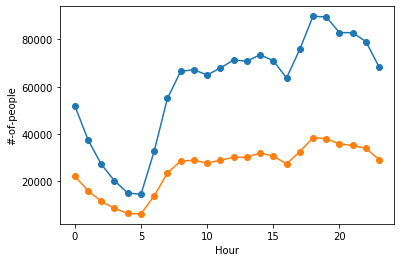

In [19]:
plt.plot(train.groupby('hr').count()[['id']], 'o-', label=train)
plt.plot(test.groupby('hr').count()[['id']], 'o-', label=test)
plt.ylabel('#-of-people')
plt.xlabel('Hour')

Text(0.5, 0, 'month')

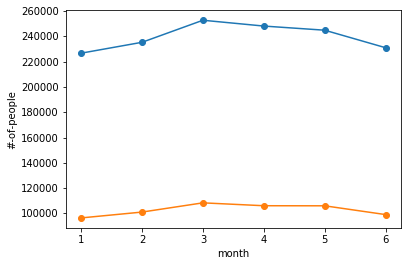

In [20]:
plt.plot(train.groupby('month').count()[['id']], 'o-', label=train)
plt.plot(test.groupby('month').count()[['id']], 'o-', label=test)
plt.ylabel('#-of-people')
plt.xlabel('month')

In [21]:
# 2. Weather check
weather = pd.read_csv('KNYC_Metars.csv')
weather['Time'] = pd.to_datetime(weather['Time'])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8787 entries, 0 to 8786
Data columns (total 14 columns):
Time          8787 non-null datetime64[ns]
Temp.         8787 non-null float64
Windchill     2295 non-null float64
Heat Index    815 non-null float64
Humidity      8787 non-null float64
Pressure      8556 non-null float64
Dew Point     8787 non-null float64
Visibility    8550 non-null float64
Wind Dir      8787 non-null object
Wind Speed    8787 non-null float64
Gust Speed    8787 non-null float64
Precip        8787 non-null float64
Events        8787 non-null object
Conditions    8787 non-null object
dtypes: datetime64[ns](1), float64(10), object(3)
memory usage: 961.2+ KB


In [22]:
weather['snow'] = 1 * (weather.Events == 'Snow') + 1 * (weather.Events == 'Fog\n\t,\nSnow')
weather['rain'] = 1 * (weather.Events == 'Rain') + 1 * (weather.Events == 'Fog\n\t,\nRain')
weather['year'] = weather['Time'].dt.year
weather['month'] = weather['Time'].dt.month
weather['day'] = weather['Time'].dt.day
weather['hr'] = weather['Time'].dt.hour

weather = weather[weather['year'] == 2016][['month', 'day', 'hr', 'Temp.', 'snow', 'rain', 'Precip', 'Visibility']]

In [23]:
weather.fillna(weather['Visibility'].mean(), inplace=True)
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8739 entries, 22 to 8760
Data columns (total 8 columns):
month         8739 non-null int64
day           8739 non-null int64
hr            8739 non-null int64
Temp.         8739 non-null float64
snow          8739 non-null int64
rain          8739 non-null int64
Precip        8739 non-null float64
Visibility    8739 non-null float64
dtypes: float64(3), int64(5)
memory usage: 614.5 KB


In [24]:
# 날짜에 맞춰서 merge
train = pd.merge(train, weather, on = ['month', 'day', 'hr'], how = 'left')
test = pd.merge(test, weather, on = ['month', 'day', 'hr'], how = 'left')

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1439183 entries, 0 to 1439182
Data columns (total 24 columns):
id                    1439183 non-null object
vendor_id             1439183 non-null int64
pickup_datetime       1439183 non-null datetime64[ns]
dropoff_datetime      1439183 non-null object
passenger_count       1439183 non-null int64
pickup_longitude      1439183 non-null float64
pickup_latitude       1439183 non-null float64
dropoff_longitude     1439183 non-null float64
dropoff_latitude      1439183 non-null float64
store_and_fwd_flag    1439183 non-null int64
trip_duration         1439183 non-null int64
year                  1439183 non-null int64
month                 1439183 non-null int64
day                   1439183 non-null int64
hr                    1439183 non-null int64
minute                1439183 non-null int64
log_trip_duration     1439183 non-null float64
rest_day              1439183 non-null bool
weekend               1439183 non-null bool
Temp.        

In [26]:
import numbers
import math

class GeoUtil:
    """
    Geographical Utils
    """
    @staticmethod
    def degree2radius(degree):
        return degree * (math.pi/180)
    
    @staticmethod
    def get_harversion_distance(lat1, lng1, lat2, lng2, round_decimal_digits=5):
    
        lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
        AVG_EARTH_RADIUS = 6371  # in km
        lat = lat2 - lat1
        lng = lng2 - lng1
        d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
        h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
        return h
    
    @staticmethod
    def get_euclidean_distance(x1, y1, x2, y2, round_decimal_digits=5):        
        """
        유클리안 Formula 이용하여 (x1,y1)과 (x2,y2) 점의 거리를 반환
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        dLon = abs(x2-x1) # 경도 차이
        if dLon >= 180:   # 반대편으로 갈 수 있는 경우
            dLon -= 360   # 반대편 각을 구한다
        dLat = y2-y1      # 위도 차이
        return round(math.sqrt(pow(dLon,2)+pow(dLat,2)),round_decimal_digits)


In [27]:
train.loc[:, 'distance_haversine'] = GeoUtil.get_harversion_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = GeoUtil.get_harversion_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1439183 entries, 0 to 1439182
Data columns (total 25 columns):
id                    1439183 non-null object
vendor_id             1439183 non-null int64
pickup_datetime       1439183 non-null datetime64[ns]
dropoff_datetime      1439183 non-null object
passenger_count       1439183 non-null int64
pickup_longitude      1439183 non-null float64
pickup_latitude       1439183 non-null float64
dropoff_longitude     1439183 non-null float64
dropoff_latitude      1439183 non-null float64
store_and_fwd_flag    1439183 non-null int64
trip_duration         1439183 non-null int64
year                  1439183 non-null int64
month                 1439183 non-null int64
day                   1439183 non-null int64
hr                    1439183 non-null int64
minute                1439183 non-null int64
log_trip_duration     1439183 non-null float64
rest_day              1439183 non-null bool
weekend               1439183 non-null bool
Temp.        

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1439183 entries, 0 to 1439182
Data columns (total 25 columns):
id                    1439183 non-null object
vendor_id             1439183 non-null int64
pickup_datetime       1439183 non-null datetime64[ns]
dropoff_datetime      1439183 non-null object
passenger_count       1439183 non-null int64
pickup_longitude      1439183 non-null float64
pickup_latitude       1439183 non-null float64
dropoff_longitude     1439183 non-null float64
dropoff_latitude      1439183 non-null float64
store_and_fwd_flag    1439183 non-null int64
trip_duration         1439183 non-null int64
year                  1439183 non-null int64
month                 1439183 non-null int64
day                   1439183 non-null int64
hr                    1439183 non-null int64
minute                1439183 non-null int64
log_trip_duration     1439183 non-null float64
rest_day              1439183 non-null bool
weekend               1439183 non-null bool
Temp.        

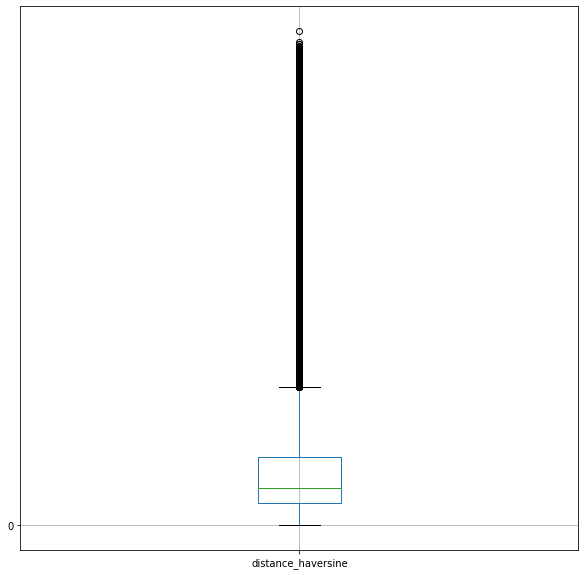

In [30]:
plt.figure(figsize=(10, 10))
boxplot = train.boxplot(column = ['distance_haversine'])
plt.yticks(np.arange(min(train['distance_haversine']), max(train['distance_haversine']), step = 50))
plt.show()

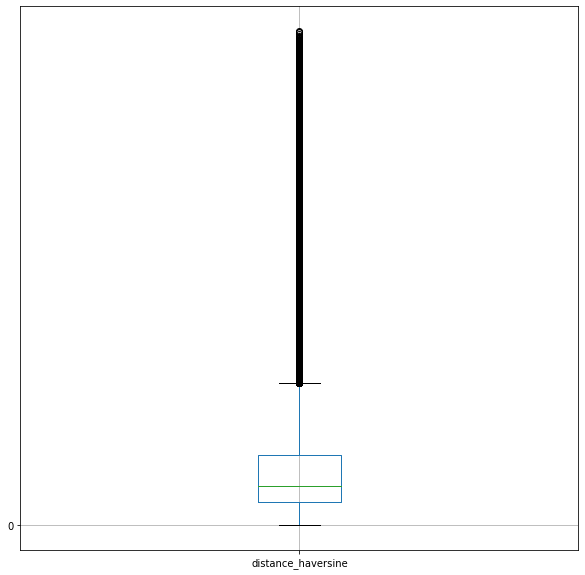

In [31]:
plt.figure(figsize=(10, 10))
boxplot = test.boxplot(column = ['distance_haversine'])
plt.yticks(np.arange(min(test['distance_haversine']), max(test['distance_haversine']), step = 50))
plt.show()

In [32]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')

month_train = pd.get_dummies(train['month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['day'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['day'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['hr'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['hr'], prefix='h', prefix_sep='_')

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1439183 entries, 0 to 1439182
Data columns (total 25 columns):
id                    1439183 non-null object
vendor_id             1439183 non-null int64
pickup_datetime       1439183 non-null datetime64[ns]
dropoff_datetime      1439183 non-null object
passenger_count       1439183 non-null int64
pickup_longitude      1439183 non-null float64
pickup_latitude       1439183 non-null float64
dropoff_longitude     1439183 non-null float64
dropoff_latitude      1439183 non-null float64
store_and_fwd_flag    1439183 non-null int64
trip_duration         1439183 non-null int64
year                  1439183 non-null int64
month                 1439183 non-null int64
day                   1439183 non-null int64
hr                    1439183 non-null int64
minute                1439183 non-null int64
log_trip_duration     1439183 non-null float64
rest_day              1439183 non-null bool
weekend               1439183 non-null bool
Temp.        

In [34]:
train.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration'], axis = 1, inplace=True)

In [35]:
train.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
            'dropoff_latitude', 'vendor_id', 'store_and_fwd_flag', 'passenger_count',
           'hr', 'month', 'day'], axis = 1, inplace=True)

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1439183 entries, 0 to 1439182
Data columns (total 11 columns):
year                  1439183 non-null int64
minute                1439183 non-null int64
log_trip_duration     1439183 non-null float64
rest_day              1439183 non-null bool
weekend               1439183 non-null bool
Temp.                 1427333 non-null float64
snow                  1427333 non-null float64
rain                  1427333 non-null float64
Precip                1427333 non-null float64
Visibility            1427333 non-null float64
distance_haversine    1439183 non-null float64
dtypes: bool(2), float64(7), int64(2)
memory usage: 112.5 MB


In [37]:
train = pd.concat([train, vendor_train, passenger_count_train, store_and_fwd_flag_train,
month_train, dom_train, hour_train], axis = 1)
train.info()
               

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1439183 entries, 0 to 1439182
Data columns (total 83 columns):
year                  1439183 non-null int64
minute                1439183 non-null int64
log_trip_duration     1439183 non-null float64
rest_day              1439183 non-null bool
weekend               1439183 non-null bool
Temp.                 1427333 non-null float64
snow                  1427333 non-null float64
rain                  1427333 non-null float64
Precip                1427333 non-null float64
Visibility            1427333 non-null float64
distance_haversine    1439183 non-null float64
vi_1                  1439183 non-null uint8
vi_2                  1439183 non-null uint8
pc_0                  1439183 non-null uint8
pc_1                  1439183 non-null uint8
pc_2                  1439183 non-null uint8
pc_3                  1439183 non-null uint8
pc_4                  1439183 non-null uint8
pc_5                  1439183 non-null uint8
pc_6                

In [38]:
y_target = train['log_trip_duration']
X_features = train.drop('log_trip_duration',axis=1, inplace=False)
print(y_target.shape, X_features.shape)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

(1439183,) (1439183, 82)


In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1439183 entries, 0 to 1439182
Data columns (total 83 columns):
year                  1439183 non-null int64
minute                1439183 non-null int64
log_trip_duration     1439183 non-null float64
rest_day              1439183 non-null bool
weekend               1439183 non-null bool
Temp.                 1427333 non-null float64
snow                  1427333 non-null float64
rain                  1427333 non-null float64
Precip                1427333 non-null float64
Visibility            1427333 non-null float64
distance_haversine    1439183 non-null float64
vi_1                  1439183 non-null uint8
vi_2                  1439183 non-null uint8
pc_0                  1439183 non-null uint8
pc_1                  1439183 non-null uint8
pc_2                  1439183 non-null uint8
pc_3                  1439183 non-null uint8
pc_4                  1439183 non-null uint8
pc_5                  1439183 non-null uint8
pc_6                

In [ ]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = xgb.XGBClassifier(n_estimators=200)

params = {'eta' : [0.05, 0.1, 0.15, 0.2, 0.5],
          'num_leaves': [32, 64 ],
          'colsample_by_tree' : [1, 0.9, 0.8, 0.7],
          'max_depth':[4, 5, 6]}


# 하이퍼 파라미터 테스트의 수행속도를 향상 시키기 위해 cv를 지정하지 않습니다. 
gridcv = GridSearchCV(xgb_clf, param_grid=params, scoring='accuracy')
gridcv.fit(X_train, y_train)

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [41]:
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

wlist = [(dtrain,'train'),(dtest,'eval')]

xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 10, wlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)

print('Modeling RMSLE %.5f' % model.best_score)


//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:3.03473	eval-rmse:3.03358
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 2 rounds.
[1]	train-rmse:1.57509	eval-rmse:1.57412
[2]	train-rmse:0.89203	eval-rmse:0.89114
[3]	train-rmse:0.60989	eval-rmse:0.609453
[4]	train-rmse:0.513879	eval-rmse:0.513868
[5]	train-rmse:0.483391	eval-rmse:0.483833
[6]	train-rmse:0.474772	eval-rmse:0.475369
[7]	train-rmse:0.470411	eval-rmse:0.471105
[8]	train-rmse:0.468071	eval-rmse:0.469001
[9]	train-rmse:0.466762	eval-rmse:0.467868
Modeling RMSLE 0.46787


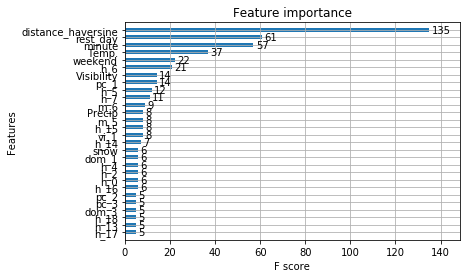

In [42]:
xgb.plot_importance(model, max_num_features=28, height=0.5)

In [43]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [44]:
train['Temp.'].fillna(train['Temp.'].mean(), inplace=True)
train['snow'].fillna(0, inplace=True)
train['rain'].fillna(0, inplace=True)
train['Precip'].fillna(train['Precip'].mean(), inplace=True)
train['Visibility'].fillna(train['Visibility'].mean(), inplace=True)

In [45]:
train = train.reset_index()
y_target = train['log_trip_duration']
X_features = train.drop('log_trip_duration',axis=1, inplace=False)
print(y_target.shape, X_features.shape)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)


(1439183,) (1439183, 83)


In [46]:

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.6
Ridge 로그 변환된 RMSE: 0.6
Lasso 로그 변환된 RMSE: 0.674


[0.5999732273983059, 0.5999730530613556, 0.6735863041213093]

In [47]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

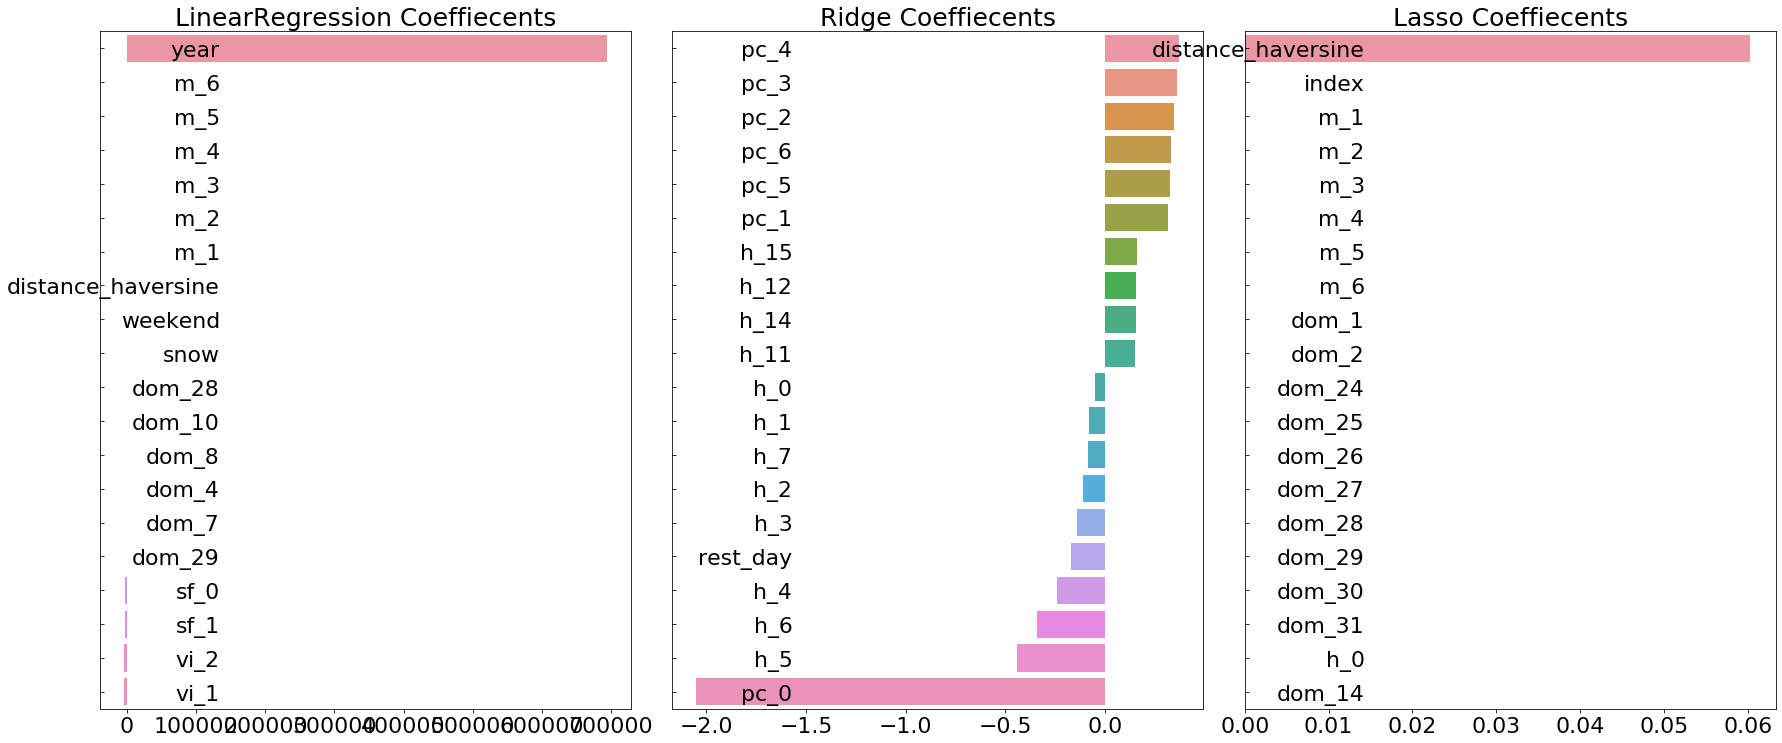

In [48]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)



In [49]:
import folium

# 가장 큰 값을 가지는 Distance의 경우 pickup 위치가 케나다로 등장. 
map_osm = folium.Map(location=[train.pickup_latitude[184925], train.pickup_longitude[184925]])
folium.Marker([train.pickup_latitude[184925], train.pickup_longitude[184925]], popup='Start').add_to(map_osm)
folium.Marker([train.dropoff_latitude[184925], train.dropoff_longitude[184925]], popup='End').add_to(map_osm)

# distance_df.loc[distance_df['Distance'].idxmax()]
map_osm

AttributeError: 'DataFrame' object has no attribute 'pickup_latitude'